<a href="https://colab.research.google.com/github/reverentOne/Econ_Projects/blob/main/484project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import and clean

In [3]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/Shared with me/Team_Narwhal-Econ_484_project/Data'
%cd '/content/gdrive/My Drive/Econ 484/Team_Narwhal-Econ_484_project/Data'

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/content/gdrive/Shared with me/Team_Narwhal-Econ_484_project/Data'
/content
[Errno 2] No such file or directory: '/content/gdrive/My Drive/Econ 484/Team_Narwhal-Econ_484_project/Data'
/content


In [71]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [72]:
df1=pd.read_csv('/content/gdrive/My Drive/Econ 484/Project/data_clean.csv', sep=',')

#Define Variables

In [73]:
y = df1['term_deposit_yes']
treatments = df1[['education_primary', 'education_secondary', 'education_tertiary']].astype('float64')
# Construct controls with exclusions
all_columns = df1.columns.tolist()
exclude_list = ['term_deposit_yes', 'education_primary', 'education_secondary', 'education_tertiary']
controls_columns = [col for col in all_columns if col not in exclude_list and col != 'Unnamed: 0']
controls = df1[controls_columns].copy()

#Visualize Variables (Can be rerun after

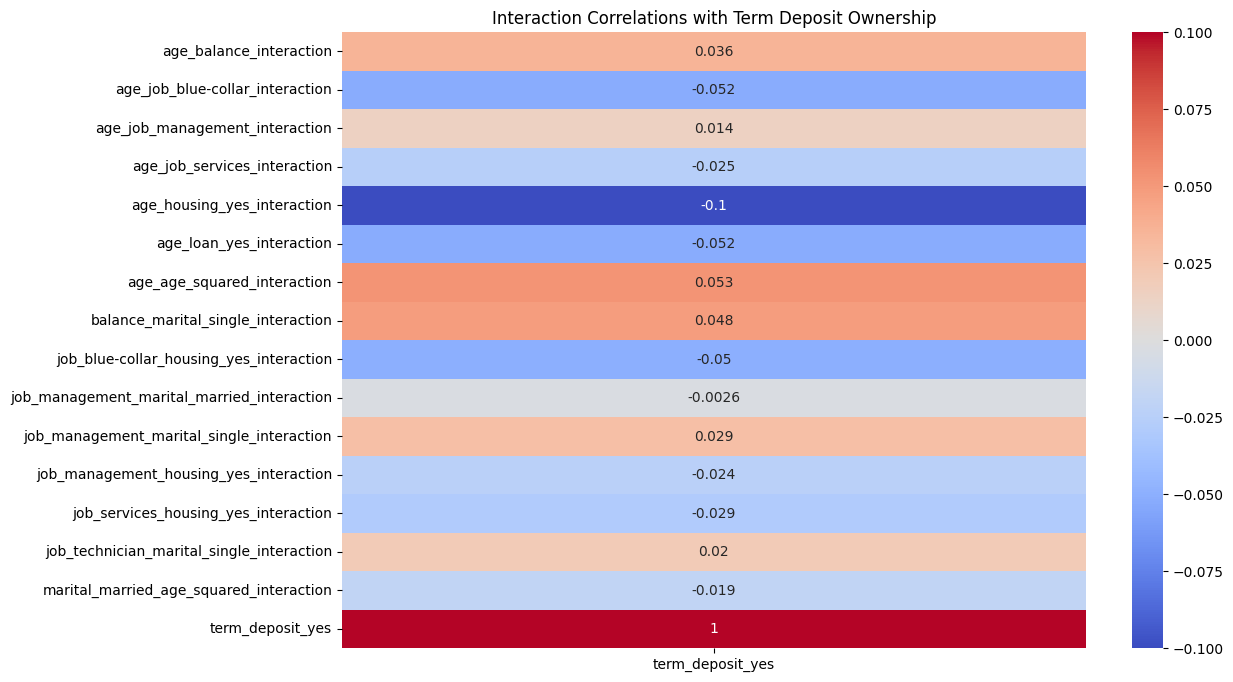

In [27]:
interaction_correlations = pd.concat([Xunion, y], axis=1).corr()['term_deposit_yes']

# Create Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(interaction_correlations.to_frame(), cmap='coolwarm', vmin=-.1, vmax=.1, annot=True)
plt.title('Interaction Correlations with Term Deposit Ownership')
plt.show()

#Add Squared Power Interactions

In [74]:
# Justification: The positive effect of higher education might plateau.
controls['education_secondary_tertiary_interaction'] = treatments['education_secondary'] * treatments['education_tertiary']

# Justification: There could be specific life phases where financial decision patterns change more drastically (Retirement maybe?)
controls['age_squared'] = controls['age'] ** 2

# Justification: Wealth accumulation source might influence risk behavior.
controls['balance_entrepreneur_interaction'] = controls['balance'] * controls['job_entrepreneur']

# Create control variable interactions (with pre-allocation because it's python)

In [75]:
controls_columns = controls.columns
control_pairs = list(itertools.combinations(controls_columns, 2))
interaction_results = {}
# Calculate interactions and fill dictionary
for feature_1, feature_2 in control_pairs:
    interaction_column = controls[feature_1] * controls[feature_2]
    interaction_column.fillna(0, inplace=True)
    interaction_results[f"{feature_1}_{feature_2}_interaction"] = interaction_column
interaction_df = pd.DataFrame(interaction_results)
controls = pd.concat([controls, interaction_df], axis=1) # Join interaction terms to the controls DataFrame
controls = controls.drop(controls_columns, axis=1) #Drop original categorical columns

#delete interaction terms with high number of zeros
print(f"Control variables before .95 non zero cutoff: {controls.shape}")
zero_threshold = 0.95  # Adjustable
zero_proportions = (controls.isnull().sum() + (controls == 0).sum()) / len(controls)
columns_to_drop = zero_proportions[zero_proportions > zero_threshold].index
controls = controls.drop(columns=columns_to_drop)
print(f"Control variables after: {controls.shape}")

Control variables before .95 non zero cutoff: (35420, 210)
Control variables after: (35420, 41)


#Simple regression

In [76]:
for col in treatments.columns:
    lm = LogisticRegression().fit(treatments[[col]], y)
    print("Simple regression ({}): {:.3f}".format(col, lm.coef_[0][0]))

Simple regression (education_primary): -0.306
Simple regression (education_secondary): -0.180
Simple regression (education_tertiary): 0.376


#Multiple Regression (Pre Lasso)

In [ ]:
lm = LinearRegression().fit(controls.join(treatments), y)
print("Multiple regression coefficients for education variables:")
for name, coef in zip(controls.columns.tolist() + treatments.columns.tolist(), lm.coef_):
    if name in treatments:
        print(f"  {name}: {coef:.3f}")

Multiple regression coefficients for education variables:
  education_primary: -0.013
  education_secondary: -0.004
  education_tertiary: 0.017


# Lasso with Cross-Validation

In [77]:
scaler = StandardScaler()
alphas_to_try = [0.01, 0.1, 0.5, 1, 5, 10, 100]
X=controls
Xnames=X.columns
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=Xnames)
lasso_cv = LassoCV(max_iter=1000,alphas=alphas_to_try).fit(X_scaled, y)
print(f"Best alpha selected: {lasso_cv.alpha_}")
# Get selected features by lasso
selected_features = Xnames[lasso_cv.coef_ != 0]
#print(f"Features selected by Lasso for outcome (y): {selected_features}")

# Lasso treatments separately to identify relevant controls
for col in treatments.columns:
    lasso_treatment_cv = LassoCV(cv=5, max_iter=1000, alphas=alphas_to_try).fit(X_scaled, treatments[col])
    selected_controls = Xnames[lasso_treatment_cv.coef_ != 0]
    #print(f"Features selected by Lasso for treatment ({col}): {selected_controls}")

# Form the union of controls (with selected features)
Xunion = X_scaled[selected_features.union(selected_controls)]

print(f"Number of features dropped: {len(controls.columns)-len(Xunion.columns)}")
print("Features remaining:")
for column in Xunion.columns:
    print(f"- {column}")

Best alpha selected: 100.0
Number of features dropped: 26
Features remaining:
- age_balance_interaction
- age_job_blue-collar_interaction
- age_job_management_interaction
- age_job_services_interaction
- age_housing_yes_interaction
- age_loan_yes_interaction
- age_age_squared_interaction
- balance_marital_single_interaction
- job_blue-collar_housing_yes_interaction
- job_management_marital_married_interaction
- job_management_marital_single_interaction
- job_management_housing_yes_interaction
- job_services_housing_yes_interaction
- job_technician_marital_single_interaction
- marital_married_age_squared_interaction


#Check for Multicolinearity

In [78]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    """
    Calculates the Variance Inflation Factor (VIF) for each feature in the dataset.
    """
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

scaler = StandardScaler()
Z=Xunion
Znames=Z.columns
Z_scaled = pd.DataFrame(scaler.fit_transform(Z), columns=Znames)

print(calculate_vif(Z_scaled))

                                     variables       VIF
0                      age_balance_interaction  1.255753
1              age_job_blue-collar_interaction  2.588106
2               age_job_management_interaction  5.362085
3                 age_job_services_interaction  2.394507
4                  age_housing_yes_interaction  1.740196
5                     age_loan_yes_interaction  1.018657
6                  age_age_squared_interaction  2.037586
7           balance_marital_single_interaction  1.301700
8      job_blue-collar_housing_yes_interaction  2.983131
9   job_management_marital_married_interaction  4.490498
10   job_management_marital_single_interaction  2.330762
11      job_management_housing_yes_interaction  2.197431
12        job_services_housing_yes_interaction  2.537707
13   job_technician_marital_single_interaction  1.158228
14     marital_married_age_squared_interaction  2.244445


# PDS Regression

In [80]:
omitted_var = 'education_primary'
treatments = treatments.reset_index(drop=True)
Xunion = Xunion.reset_index(drop=True)
rhs = pd.concat([treatments, Xunion], axis=1)
rhs = rhs.drop(omitted_var, axis=1)

# Logistic Regression
logm = LogisticRegression().fit(rhs, y)
print(f"\nRegression results with '{omitted_var}' omitted:\n")

results = pd.DataFrame({'Coefficient': logm.coef_[0],
                        'Odds Ratio': np.exp(logm.coef_[0])},
                       index=rhs.columns)

for index, row in results.iterrows():
    coef, odds_ratio = row['Coefficient'], row['Odds Ratio']
    approx_pct_change = (odds_ratio - 1) * 100
    print(f"- {index}:")
    print(f"   Coefficient: {coef:.3f}")
    print(f"   Odds Ratio: {odds_ratio:.2f}")
    print(f"   Approximate % Change in Odds: {approx_pct_change:.1f}%")


Regression results with 'education_primary' omitted:

- education_secondary:
   Coefficient: 0.230
   Odds Ratio: 1.26
   Approximate % Change in Odds: 25.9%
- education_tertiary:
   Coefficient: 0.487
   Odds Ratio: 1.63
   Approximate % Change in Odds: 62.8%
- age_balance_interaction:
   Coefficient: 0.017
   Odds Ratio: 1.02
   Approximate % Change in Odds: 1.7%
- age_job_blue-collar_interaction:
   Coefficient: -0.148
   Odds Ratio: 0.86
   Approximate % Change in Odds: -13.8%
- age_job_management_interaction:
   Coefficient: -0.162
   Odds Ratio: 0.85
   Approximate % Change in Odds: -14.9%
- age_job_services_interaction:
   Coefficient: -0.095
   Odds Ratio: 0.91
   Approximate % Change in Odds: -9.0%
- age_housing_yes_interaction:
   Coefficient: -0.339
   Odds Ratio: 0.71
   Approximate % Change in Odds: -28.8%
- age_loan_yes_interaction:
   Coefficient: -0.189
   Odds Ratio: 0.83
   Approximate % Change in Odds: -17.2%
- age_age_squared_interaction:
   Coefficient: 0.287
   O

'\nomitted_var = \'education_primary\'\ntreatments = treatments.reset_index(drop=True)\nXunion = Xunion.reset_index(drop=True)\nrhs = pd.concat([treatments, Xunion], axis=1)\nrhs = rhs.drop(omitted_var, axis=1)\n# Logistic Regression\nlogm = LogisticRegression().fit(rhs, y)\nprint(f"\nRegression results with \'{omitted_var}\' omitted:\n")\n#Fit to Find p-value\nlogit_model = sm.Logit(y, rhs)\nlogit_result = logit_model.fit()\n\n\nresults = pd.DataFrame({\'Coefficient\': logit_result.params,\n                        \'Odds Ratio\': np.exp(logit_result.params),\n                        \'P-Value\': logit_result.pvalues},\n                        index=rhs.columns)\n\nfor index, row in results.iterrows():\n    coef, odds_ratio, pvalue = row[\'Coefficient\'], row[\'Odds Ratio\'], row[\'P-Value\']\n    approx_pct_change = (odds_ratio - 1) * 100\n    print(f"- {index}:")\n    print(f"   Coefficient: {coef:.3f}")\n    print(f"   Odds Ratio: {odds_ratio:.2f}")\n    print(f"   Approximate % Cha

#Visualization

In [ ]:
import statsmodels.api as sm # pip install statsmodels

def calculate_odds_ratio(coef, value):
    return np.exp(coef * value)

# Conditional Effects for 'age_job_management_interaction'
age_coef = df1.loc['age', 'Coefficient']
job_mgmt_coef = df1.loc['job_management', 'Coefficient']
interaction_coef = df1.loc['age_job_management_interaction', 'Coefficient']

odds_ratio_age_mgmt = calculate_odds_ratio(age_coef + interaction_coef, 1)
odds_ratio_age_no_mgmt = calculate_odds_ratio(age_coef, 0)

print(f"Odds ratio for age when job_management = 1: {odds_ratio_age_mgmt:.2f}")
print(f"Odds ratio for age when job_management = 0: {odds_ratio_age_no_mgmt:.2f}")

# ... (Similar calculations for other interactions) ...

# Marginal Effects (Example)
logit_mod = sm.Logit(y, rhs)
logit_res = logit_mod.fit()
print(logit_res.get_margeff().summary())

KeyError: 'Coefficient'

My Analysis:



#Debiased robustness checks with machine learning